In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler

import os
import h5py
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
device = 'cuda'
from time import time

import losses
from utils import ScatteringProblemForward

In [9]:
filename_out    = 'output/ff_nn.pt'
# Model to load and continue training. Ignored if empty string
filename_in     = ''
# Compute device to perform the training on, 'cuda' or 'cpu'
device          = 'cuda'
# Use interactive visualization of losses and other plots. Requires visdom
interactive_visualization = False # check first how this visdom works
# Run a list of python functions at test time after eacch epoch
# See toy_modes_train.py for reference example
test_time_functions = []

#######################
#  Training schedule  #
#######################

# Initial learning rate
lr_init         = 5.0e-3
#Batch size
batch_size      = 128
# Total number of epochs to train for
n_epochs        = 50

# End the epoch after this many iterations (or when the train loader is exhausted)
n_its_per_epoch = 200
# For the first n epochs, train with a much lower learning rate. This can be
# helpful if the model immediately explodes.
pre_low_lr      = 0
# Decay exponentially each epoch, to final_decay*lr_init at the last epoch.
final_decay     = 0.02
# L2 weight regularization of model parameters
l2_weight_reg   = 1e-5
# Parameters beta1, beta2 of the Adam optimizer
adam_betas = (0.9, 0.95)

#####################
#  Data dimensions  #
#####################
ndim_x_class     = 3
ndim_x_features     = 7

ndim_y     = 512

############
#  Losses  #
############

train_forward_mmd    = True

lambd_mmd_for_class    = 10
lambd_mmd_for_feature  = 50

# For noisy forward processes, the sigma on y (assumed equal in all dimensions).
# This is only used if mmd_back_weighted of train_max_likelihoiod are True.
y_uncertainty_sigma = 0.12 * 4

mmd_forw_kernels = [(0.2, 1/2), (1.5, 1/2), (3.0, 1/2)]
mmd_back_kernels = [(0.2, 1/2), (0.2, 1/2), (0.2, 1/2)]
mmd_back_weighted = True

###########
#  Model  #
###########

# Initialize the model parameters from a normal distribution with this sigma
init_scale = 0.10
#
N_blocks   = 25
#
hidden_layer_sizes = 1024
#
use_permutation = True
#
verbose_construction = False

In [10]:
lp = ScatteringProblemForward( device,  batch_size, ndim_x_class, ndim_x_features, ndim_y, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, 
                        lambd_mmd_for_class, lambd_mmd_for_feature, mmd_back_weighted, y_uncertainty_sigma, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [11]:
lp.read_data('/home/slaskina/simulations')
lp.normalize_inputs()

In [12]:
lp.create_loaders()

In [13]:
class ForwardScatteringLinear(nn.Module):
    def __init__(self, in_dim, out_dim,N_blocks, hidden_layers) -> None:
        super().__init__()
        self.linear_in = nn.Linear(in_dim, hidden_layers)
        self.linear_middle = nn.Linear(hidden_layers,hidden_layers)
        self.linear_out = nn.Linear(hidden_layers,out_dim)
        self.N_blocks = N_blocks
    def forward(self, x):
        x = F.relu(self.linear_in(x))
        for _ in range(self.N_blocks):
            x = F.relu(self.linear_middle(x))
        x = self.linear_out(x)
        return x
model_simple_linear =ForwardScatteringLinear(ndim_y,ndim_x_class+ndim_x_features,N_blocks, hidden_layer_sizes)

In [14]:
lp.set_model(model_simple_linear)
lp.set_optimizer()

In [15]:
lp.train()

Epoch 0: training loss: 2.7111068004515113, test loss: 2.6732804567917534
Epoch 1: training loss: 2.699021446995619, test loss: 2.6788978472999903
Epoch 2: training loss: 2.696778777169018, test loss: 2.718393388001815
Epoch 3: training loss: 2.7146191189928754, test loss: 2.678672697233117
Epoch 4: training loss: 2.695935138841955, test loss: 2.674680523250414
Epoch 5: training loss: 2.701174265000878, test loss: 2.6610057146652886
Epoch 6: training loss: 2.710884335564404, test loss: 2.691749209943025
Epoch 7: training loss: 2.6920620144867318, test loss: 2.642733397691146
Epoch 8: training loss: 2.6975709868640436, test loss: 2.6986906113831894
Epoch 9: training loss: 2.7138193642220845, test loss: 2.6176615175993545
Epoch 10: training loss: 2.701337261897762, test loss: 2.6793582854063613
Epoch 11: training loss: 2.686398125276333, test loss: 2.63477521357329
Epoch 12: training loss: 2.6924323047079692, test loss: 2.682429904523103
Epoch 13: training loss: 2.709842114913754, test l

In [16]:
df_train = lp.create_table_from_outcomes(lp.make_prediction(lp.train_indices), lp.train_indices)
df_val = lp.create_table_from_outcomes(lp.make_prediction(lp.val_indices), lp.val_indices) 
df_test = lp.create_table_from_outcomes(lp.make_prediction(lp.test_indices), lp.test_indices)

In [17]:

from visualizations import plot_outcomes_identified, describe_false_shapes, describe_positive_shapes


Accuracy is 33.16%
MSE for radius per shape for correctly identified instances as follows: sphere: 93546387135058067620760649728.0000, hardsphere: inf and cylinder: inf
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 88041222294522018537861545984.0000, hardsphere: inf and cylinder: inf
MSE for cylinder length for correctly identified instances: inf
MSE for cylinder length polydispersity for correctly identified instances: inf
MSE for cylinder length for correctly identified instances: inf
      true_shape    feature         value
0         sphere    sampled  4.013916e+00
1         sphere  predicted  2.935725e+14
10        sphere    sampled  6.492275e+00
11        sphere  predicted  2.775525e+14
20        sphere    sampled  2.638311e+00
...          ...        ...           ...
34791     sphere  predicted  3.080930e+14
34800     sphere    sampled  1.095803e+00
34801     sphere  predicted  4.175419e+14
34810     sphere    sampled  6.178206e+

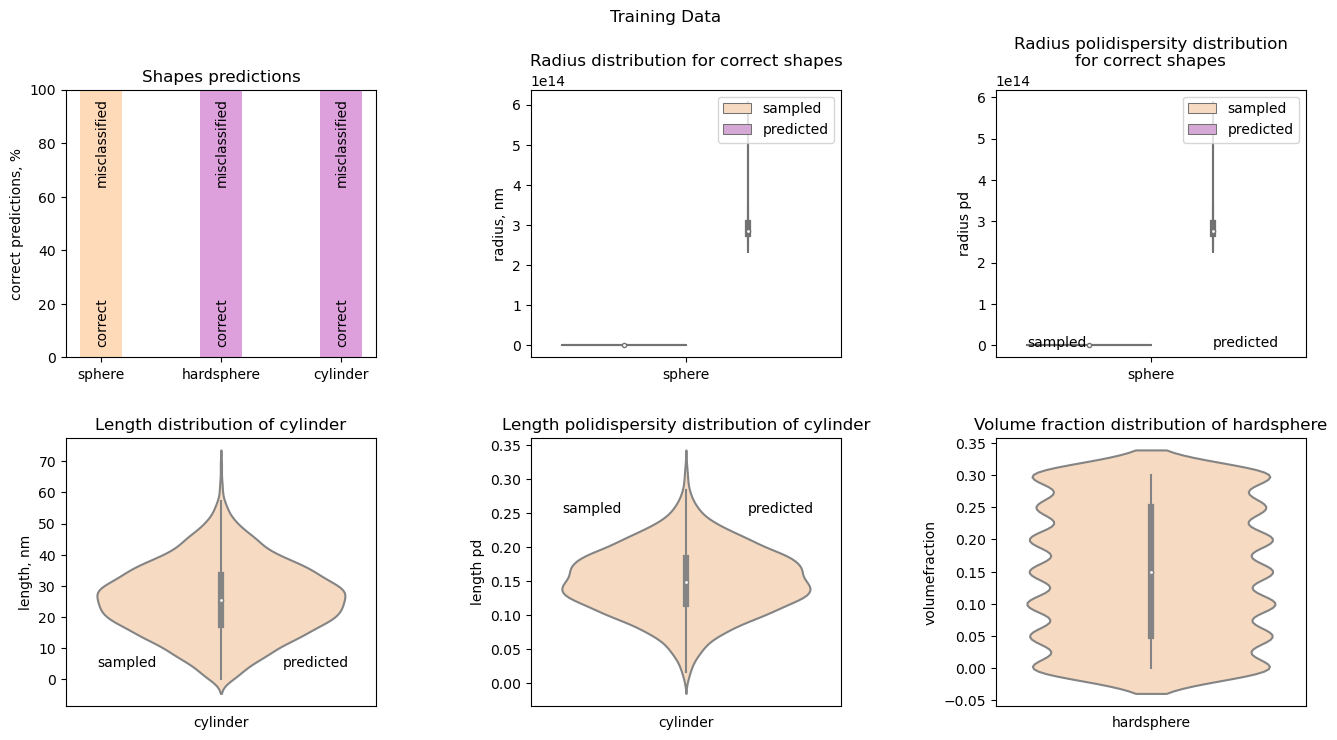

In [18]:
plot_outcomes_identified(df_train, 'Training')

Accuracy is 33.87%
MSE for radius per shape for correctly identified instances as follows: sphere: 91960352017587400057869565952.0000, hardsphere: inf and cylinder: inf
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 86548529472951752382264377344.0000, hardsphere: inf and cylinder: inf
MSE for cylinder length for correctly identified instances: inf
MSE for cylinder length polydispersity for correctly identified instances: inf
MSE for cylinder length for correctly identified instances: inf
      true_shape    feature         value
0         sphere    sampled  6.340048e+00
1         sphere  predicted  2.778939e+14
10        sphere    sampled  2.095053e+00
11        sphere  predicted  3.591152e+14
20        sphere    sampled  8.735443e+00
...          ...        ...           ...
10131     sphere  predicted  2.818249e+14
10140     sphere    sampled  6.485870e+00
10141     sphere  predicted  2.779305e+14
10150     sphere    sampled  2.876734e+

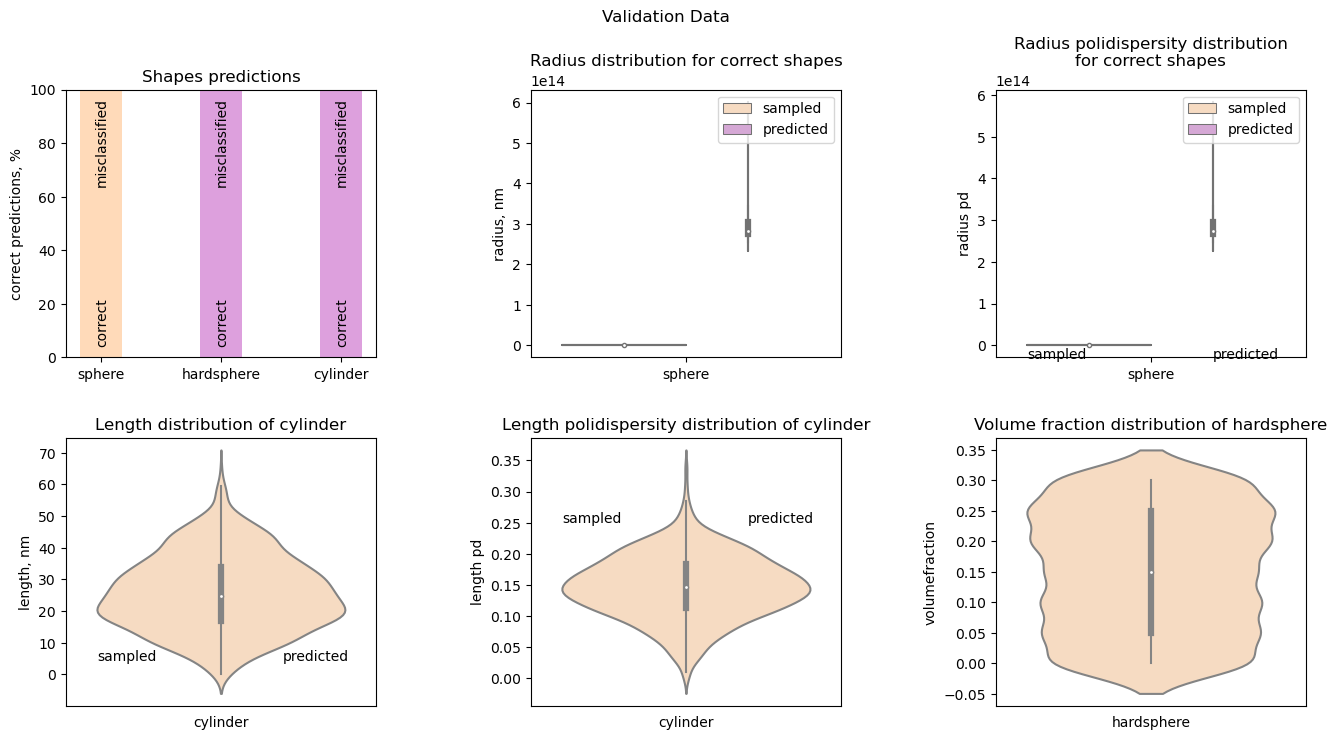

In [19]:
plot_outcomes_identified(df_val, 'Validation')

Accuracy is 33.47%
[100.0, 0.0, 0.0]
MSE for radius per shape for correctly identified instances as follows: sphere: 98337076816201870861408403456.0000, hardsphere: inf and cylinder: inf
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 92549986696638503959251648512.0000, hardsphere: inf and cylinder: inf
MSE for cylinder length for correctly identified instances: inf
MSE for cylinder length polydispersity for correctly identified instances: inf
MSE for cylinder length for correctly identified instances: inf


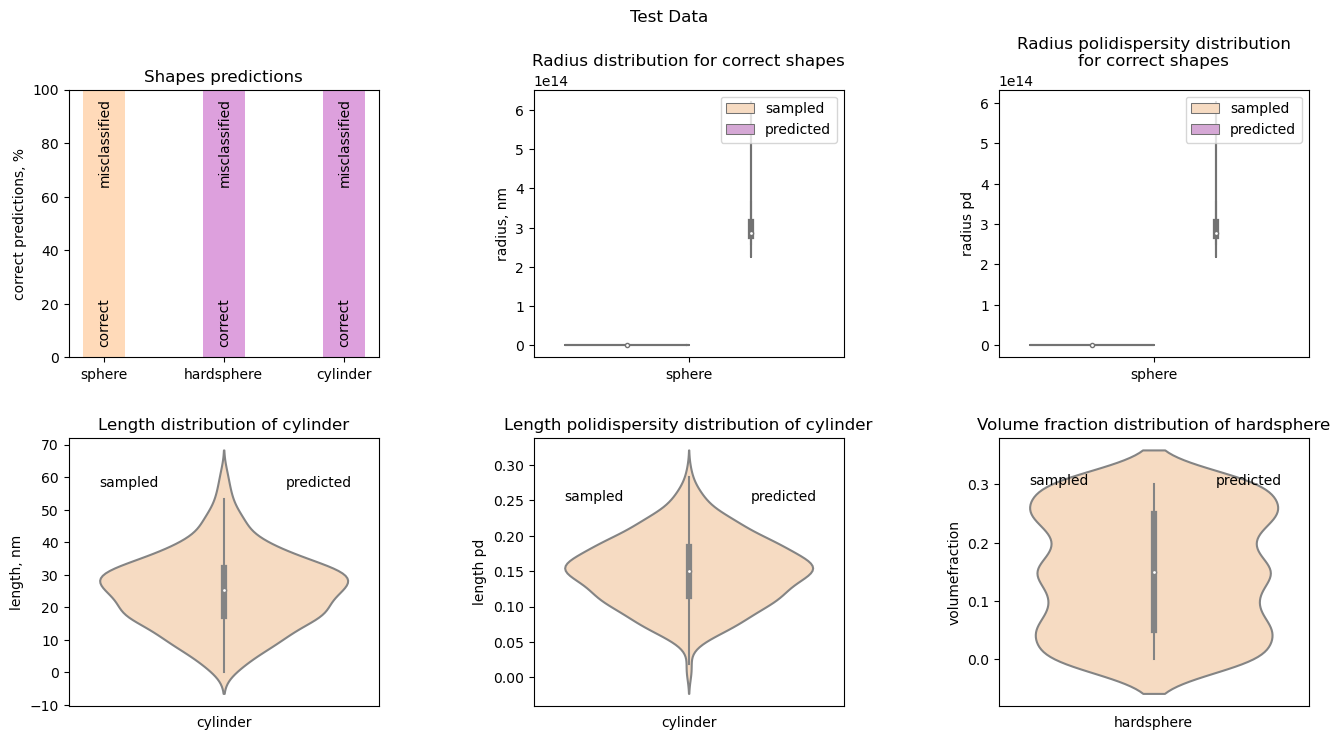

In [21]:
plot_outcomes_identified(df_test, 'Test')

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import matplotlib.gridspec as gridspec


def MSE(sampled, predicted):
    if len(sampled) == 0:
        return np.inf
    else:
        return mean_squared_error(sampled, predicted)

def set_value(row, true_shape, colname_true, colname_pred):
    if row.true_shape == true_shape:
        return row[colname_true]
    else:
        return row[colname_pred]
def set_label(row, true_shape, label_true, label_false):
    if row.true_shape == true_shape:
        return label_true
    else:
        return label_false


def plot_outcomes_identified(df, data_name):
    print('Accuracy is {0:.2%}'.format((df.true_shape == df.pred_shape).sum()/len(df)))
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 8))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.3)
    shapes = ['sphere', 'hardsphere', 'cylinder']
    # shape classified correctly
    correct = [((df.true_shape == 0) & (df.pred_shape == 0)).sum(),((df.true_shape == 1) & (df.pred_shape == 1)).sum(),((df.true_shape == 2) & (df.pred_shape == 2)).sum()]
    wrong = [((df.true_shape == 0) & (df.pred_shape != 0)).sum(),((df.true_shape == 1) & (df.pred_shape != 1)).sum(),((df.true_shape == 2) & (df.pred_shape != 2)).sum()]
    correct = [correct[i]/(correct[i]+ wrong[i])*100 for i in range(len(correct))]
    wrong = [100-correct[i] for i in range(len(wrong))]
    print(correct)
    ax = axes[0,0]
    ax.bar(shapes, correct, width=0.35, label='correct', color = 'peachpuff')
    ax.bar(shapes, wrong, width=0.35,bottom=correct, label='misclassified', color = 'plum')
    ax.set_ylabel('correct predictions, %')
    ax.set_title('Shapes predictions')
    ax.text(-0.05, 5, 'correct', rotation = 90)
    ax.text(0.95, 5, 'correct', rotation = 90)
    ax.text(1.95, 5, 'correct', rotation = 90)
    
    ax.text(-0.05, 65, 'misclassified', rotation = 90)
    ax.text(0.95, 65, 'misclassified', rotation = 90)
    ax.text(1.95, 65, 'misclassified', rotation = 90)

    # radius of a correctly identified shapes
    #print('Total radius MSE is {err:.2f}'.format(err= mean_squared_error(df.radius, df.pred_radius)))
    print('MSE for radius per shape for correctly identified instances as follows: sphere: {sMSE:.4f}, hardsphere: {hsMSE:.4f} and cylinder: {cMSE:.4f}'.format\
        (sMSE = MSE(df[(df.true_shape == 0) & (df.pred_shape == 0)].radius, df[(df.true_shape == 0) & (df.pred_shape == 0)].pred_radius), 
         hsMSE = MSE(df[(df.true_shape == 1) & (df.pred_shape == 1)].radius, df[(df.true_shape == 1) & (df.pred_shape == 1)].pred_radius),
         cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].radius, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_radius)))
      
    #print('Total radius MSE is {err:.2f}'.format(err= mean_squared_error(df.radius, df.pred_radius)))
    print('MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: {sMSE:.4f}, hardsphere: {hsMSE:.4f} and cylinder: {cMSE:.4f}'.format\
        (sMSE = MSE(df[(df.true_shape == 0) & (df.pred_shape == 0)].radius_pd, df[(df.true_shape == 0) & (df.pred_shape == 0)].pred_radius_pd), 
         hsMSE = MSE(df[(df.true_shape == 1) & (df.pred_shape == 1)].radius_pd, df[(df.true_shape == 1) & (df.pred_shape == 1)].pred_radius_pd),
         cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].radius_pd, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_radius_pd)))

    print('MSE for cylinder length for correctly identified instances: {cMSE:.4f}'.format\
        (cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].length, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_length)))
    print('MSE for cylinder length polydispersity for correctly identified instances: {cMSE:.4f}'.format\
        (cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].length_pd, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_length_pd)))
    print('MSE for cylinder length for correctly identified instances: {hMSE:.4f}'.format\
        (hMSE = MSE(df[(df.true_shape == 1) & (df.pred_shape == 1)].volfraction, df[(df.true_shape == 1) & (df.pred_shape == 1)].pred_volfraction)))
    #stacked df to create violinplots
    df_stacked = df[df.true_shape ==df.pred_shape].drop(columns = ['pred_shape']).set_index('true_shape').stack().reset_index().rename(columns = {'level_1':'feature', 0:'value'})
    df_stacked.loc[df_stacked.true_shape == 0, 'true_shape'] = "sphere"
    df_stacked.loc[df_stacked.true_shape == 1, 'true_shape'] = "hardsphere"
    df_stacked.loc[df_stacked.true_shape == 2, 'true_shape'] = "cylinder"

    ax = axes[0,1]
    data = df_stacked[(df_stacked.feature == 'radius')|(df_stacked.feature == 'pred_radius')]
    data.loc[data.feature == 'radius', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_radius', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = ['true_shape','feature'], ascending = False), x="true_shape", y="value", hue="feature", split = False, ax=ax, palette=['peachpuff', 'plum'])
    ax.set_title('Radius distribution for correct shapes')
    ax.set_ylabel("radius, nm")
    ax.set_xlabel("")
    #ax.set_ylim([-5,10])
    ax.legend()

    ax = axes[0,2]
    data = df_stacked[(df_stacked.feature == 'radius_pd')|(df_stacked.feature == 'pred_radius_pd')]
    data.loc[data.feature == 'radius_pd', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_radius_pd', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = ['true_shape','feature'], ascending = False), x="true_shape", y="value", hue="feature", split = False, ax=ax, palette=['peachpuff', 'plum'])
    ax.set_title('Radius polidispersity distribution\nfor correct shapes')
    ax.legend()
    ax.set_ylabel("radius pd")
    ax.set_xlabel("")
    #ax.set_ylim([-1,1])

    # length
    df_stacked = df.set_index(['true_shape', 'pred_shape']).stack().reset_index().rename(columns = {'level_2':'feature', 0:'value'}).assign(y=1)

    ax = axes[1,0]
    data = df_stacked[((df_stacked.feature == 'length')&(df_stacked.true_shape ==2))|((df_stacked.feature == 'pred_length')&(df_stacked.pred_shape == 2))]
    data.loc[data.feature == 'length', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_length', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False), x="y",y = "value", hue="feature",split = False, ax=ax, palette=['peachpuff', 'plum'] )
    ax.set_title('Length distribution of cylinder')
    ax.set_xlabel("cylinder")
    ax.set_ylabel("length, nm")
    ax.set_xticks([])
    ax.get_legend().remove()
    ax.text(-.4, 57, "sampled")
    ax.text(0.2, 57, "predicted")
    #ax.set_ylim([-10,50])

    ax = axes[1,1]
    data = df_stacked[((df_stacked.feature == 'length_pd')&(df_stacked.true_shape ==2))|((df_stacked.feature == 'pred_length_pd')&(df_stacked.pred_shape == 2))]
    data.loc[data.feature == 'length_pd', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_length_pd', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False),  x="y",y = "value", hue="feature", split = False, ax=ax, palette=['peachpuff', 'plum'])
    ax.set_title('Length polidispersity distribution of cylinder')
    ax.set_xlabel("cylinder")
    ax.set_ylabel("length pd")
    ax.set_xticks([])
    ax.get_legend().remove()
    ax.text(-.4, 0.25, "sampled")
    ax.text(0.2, 0.25, "predicted")
    #ax.set_ylim([-1,1])

    ax = axes[1,2]
    data = df_stacked[((df_stacked.feature == 'volfraction')&(df_stacked.true_shape ==1))|((df_stacked.feature == 'pred_volfraction')&(df_stacked.pred_shape == 1))]
    data.loc[data.feature == 'volfraction', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_volfraction', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False), x="y",y = "value", hue="feature", split = False, ax=ax, palette=['peachpuff', 'plum'])
    ax.set_title('Volume fraction distribution of hardsphere')
    ax.set_xlabel("hardsphere")
    ax.set_ylabel("volumefraction")
    ax.set_xticks([])
    ax.get_legend().remove()
    ax.text(-.4, 0.3, "sampled")
    ax.text(0.2, 0.3, "predicted")
    #ax.set_ylim([-0,1])

    plt.suptitle('{d} Data'.format(d = data_name))
    

